## Imports

In [10]:
import numpy as np
import pocketvna
import os
import matplotlib.pyplot as plt
from stlab.devices.Vaunix_Phase import Vaunix_Phase
import time

## VNA

In [2]:
# Connecting the VNA
driver = pocketvna.Driver()

print('Driver is created: {} devices connected..'.format(driver.count()))
for i in range(0, driver.count()):
    print('Device {}'.format(i))
    print('\t {}'.format(driver.info_at(i)))

if not driver.connect_to(0):
    print('Failed to connect')

Driver is created: 1 devices connected..
Device 0
	 {'index': 0, 'path:': b'\\\\?\\hid#vid_03eb&pid_2402#7&1fc8f206&0&0000#{4d1e55b2-f16f-11cf-88cb-001111000030}', 'version': 512, 'SN': '', 'product': 'PocketVNA', 'vendor': 'Martin', 'read': True, 'write': True}


## Phase Shifters

In [9]:
# Connecting the phase shifters
ph1 = Vaunix_Phase(23869)
ph2 = Vaunix_Phase(19164)

# Setting the frequency to the minimum
ph1.SetFrequency(4200000000)
ph2.SetFrequency(4200000000)

# Setting the phase to the minimum
ph1.SetPhase(0)
ph2.SetPhase(0)

# Checking if the phases and the frequencies are set correctly
print("Phase of Phase Shifter 1: {}\nFrequency of Phase Shifter 1: {}".format(ph1.GetPhase(), ph1.GetFrequency()))
print("Phase of Phase Shifter 2: {}\nFrequency of Phase Shifter 2: {}".format(ph2.GetPhase(), ph2.GetFrequency()))

status: -2147287040
status: -2147287040
Phase of Phase Shifter 1: 0.0
Frequency of Phase Shifter 1: 4200000000.0
Phase of Phase Shifter 2: 0.0
Frequency of Phase Shifter 2: 4200000000.0


## Calibration Folder

In [4]:
# Setting the folder where the calibration data will be stored

# Main folder
calibration_folder_name = "Calibration_5"

# Checking if the folder exists. If it doesn't it will create the folder
if not os.path.exists(calibration_folder_name):
    os.mkdir(calibration_folder_name)

## Measurement Folder

In [5]:
# Setting the folder where the measurement data will be stored

# Main folder
measurement_folder_name = "Measurements_5"

# Checking if the folder exists. If it doesn't it will create the folder
if not os.path.exists(measurement_folder_name):
    os.mkdir(measurement_folder_name)

## Calibration data

In [6]:
# ------------------------Calibrating Single Frequency------------------------

# saving the data
def data_saving(s21, name):
    file_name ="cal-s21_{}_4_2GHz.dat".format(name)
    save_name = os.path.join("Calibration_5", file_name)
    data = np.column_stack((s21.real, s21.imag))
    np.savetxt(save_name, data)
    print("Saved: " + save_name)

#  -------------------------Setup of parameters and constants----------------------
# Start at 4_000_000_000 
freq = 4200000000
# Average amount of measurements per point
average = 20

#  -------------------------------Open Measurement---------------------------------
# Measuring
input("Open Measurement")
s11, s21, s12, s22 = driver.single_scan(freq, average, pocketvna.NetworkParams.S21)

# Saving the data
data_saving(s21, "open")

#  ------------------------------through Measurement-------------------------------
# Measuring
input("Through Measurement")
s11, s21, s12, s22 = driver.single_scan(freq, average, pocketvna.NetworkParams.S21)

# Saving the data
data_saving(s21, "through")

Open Measurement
Saved: Calibration_5\cal-s21_open_4_2GHz.dat
Through Measurement
Saved: Calibration_5\cal-s21_through_4_2GHz.dat


## Measuring

In [15]:
#------------------------------------------Measurements--------------------------------------------

def data_saving(s21, name, start, step_size, phase_1, phase_2):
    file_name ="{}_4_2GHz_{}-start_{}-stepsize.dat".format(name, start, step_size)
    save_name = os.path.join("Measurements_5", file_name)
    data = np.column_stack((s21.real, s21.imag))
    np.savetxt(save_name, data)
    print("Saved: " + save_name)

def calibrating(s21):
    # Setting the file name of the calibration open calibration data
    file_name = "cal-s21_open_4_2GHz.dat"
    # Setting the path where the file can be found
    save_name = os.path.join("Calibration_5", file_name)
    # Load the data
    cal_open = np.loadtxt(save_name)
    # Get the data and put the real and imaginary part together again
    t_open = cal_open[0] + cal_open[1] * 1j
    
    # Setting the file name of the calibration open calibration data
    file_name = "cal-s21_through_4_2GHz.dat"
    # Setting the path where the file can be found
    save_name = os.path.join("Calibration_5", file_name)
    # Load the data
    cal_through = np.loadtxt(save_name)
    # Get the data and put the real and imaginary part together again
    t_through = cal_through[0] + cal_through[1] * 1j
    
    return (s21 - t_open) / (t_through - t_open)

#---------------------------------------------Setup------------------------------------------------

freq = 4200000000
average = 20
step_size = 36
start = 0
end = start + 360
phase = np.arange(start, 361, step_size)
phase_1 = 0
phase_2 = 0
ph1.SetFrequency(freq)
ph2.SetFrequency(freq)

s21 = np.zeros(len(phase), dtype=np.complex)

#------------------------------------------Measurement--------------------------------------------
for i in range(len(phase)):
    if (phase[i] + phase_1) > 360:
        ph1.SetPhase(phase_1 + phase[i] - 360)
    elif (phase[i] + phase_1) > 720:
        ph1.SetPhase(phase_1 + phase[i] - 720)
    else:
        ph1.SetPhase(phase_1 + phase[i])
        
    if (phase[i] + phase_2) > 360:
        ph2.SetPhase(phase_2 + phase[i] - 360)
    elif (phase[i] + phase_2) > 720:
        ph2.SetPhase(phase_2 + phase[i] - 720)
    else:
        ph2.SetPhase(phase_2 + phase[i])
    
    time.sleep(0.1)
    s11, s21[i], s12, s22 = driver.single_scan(freq, average, pocketvna.NetworkParams.S21)

data_saving(s21, "s21", start, step_size, phase_1, phase_2)
cal = calibrating(s21)
data_saving(cal, "s21-cal", start, step_size, phase_1, phase_2)

Saved: Measurements_5\s21_4_2GHz_0-start_36-stepsize.dat
Saved: Measurements_5\s21-cal_4_2GHz_0-start_36-stepsize.dat


## Plotting

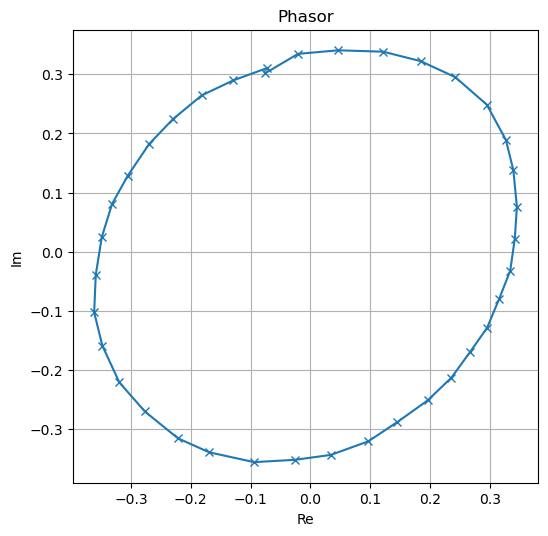

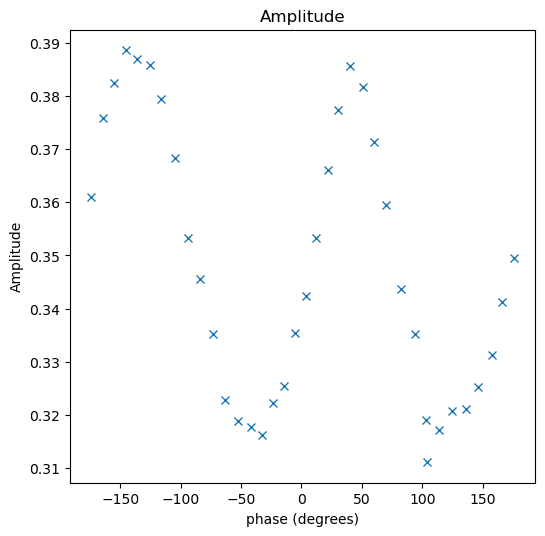

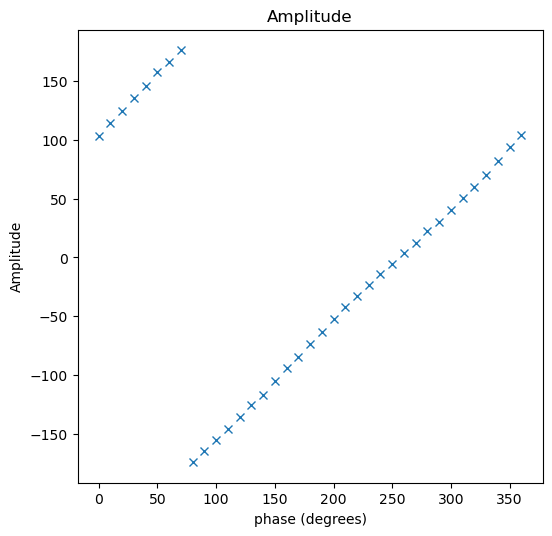

In [46]:
def opening_data(name, start, step_size):
    # Setting the file name of the calibration open calibration data
    file_name = "{}_4_2GHz_{}-start_{}-stepsize.dat".format(name, start, step_size)
    # Setting the path where the file can be found
    save_name = os.path.join("Measurements_5", file_name)
    # Load the data
    temp = np.loadtxt(save_name)
    # Get the data and put the real and imaginary part together again
    return temp[:, 0] + temp[:, 1] * 1j
    
    
    
def plot_phasor(s21):
#     fig = plt.figure(1)
    fig = plt.figure(1)
#     ax = fig.add_subplot(1, 1, 1)

#     # Move left y-axis and bottim x-axis to centre, passing through (0,0)
#     ax.spines['left'].set_position('center')
#     ax.spines['bottom'].set_position('center')

#     # Eliminate upper and right axes
#     ax.spines['right'].set_color('none')
#     ax.spines['top'].set_color('none')

#     # Show ticks in the left and lower axes only
#     ax.xaxis.set_ticks_position('bottom')
#     ax.yaxis.set_ticks_position('left')

    plt.plot(s21.real, s21.imag, '-x')
    plt.grid()
    plt.xlabel("Re")
    plt.ylabel("Im")
    plt.title("Phasor")
    
def plot_amplitude(s21):
    
    amp = np.sqrt(s21.real**2 + s21.imag**2)
    phase = 180 * np.arctan2(s21.imag, s21.real)/np.pi
    
    plt.figure(2)
    plt.plot(phase, amp, 'x')
    plt.xlabel("phase (degrees)")
    plt.ylabel("Amplitude")
    plt.title("Amplitude")
    
def plot_phase(s21, phase):
    arg = 180 * np.arctan2(s21.imag, s21.real)/np.pi
    
    plt.figure(3)
    plt.plot(phase, arg, 'x')
    plt.xlabel("phase (degrees)")
    plt.ylabel("Amplitude")
    plt.title("Amplitude")
    
    
freq = 4200000000
average = 20
step_size = 10
start = 0
end = start + 360
phase = np.arange(start, 361, step_size)
plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams['figure.dpi'] = 100

s21 = opening_data("s21", start, step_size)
s21_cal = opening_data("s21-cal", start, step_size)

plot_phasor(s21_cal)
plot_amplitude(s21_cal)
plot_phase(s21_cal, phase)

## Plotting multiple

In [ ]:
def opening_data(name, start, step_size):
    # Setting the file name of the calibration open calibration data
    file_name = "{}_4_2GHz_{}-start_{}-stepsize.dat".format(name, start, step_size)
    # Setting the path where the file can be found
    save_name = os.path.join("Measurements_5", file_name)
    # Load the data
    temp = np.loadtxt(save_name)
    # Get the data and put the real and imaginary part together again
    return temp[:, 0] + temp[:, 1] * 1j
    
    
    
def plot_phasor(s21):
#     fig = plt.figure(1)
    fig = plt.figure(1)
#     ax = fig.add_subplot(1, 1, 1)

#     # Move left y-axis and bottim x-axis to centre, passing through (0,0)
#     ax.spines['left'].set_position('center')
#     ax.spines['bottom'].set_position('center')

#     # Eliminate upper and right axes
#     ax.spines['right'].set_color('none')
#     ax.spines['top'].set_color('none')

#     # Show ticks in the left and lower axes only
#     ax.xaxis.set_ticks_position('bottom')
#     ax.yaxis.set_ticks_position('left')

    plt.plot(s21.real, s21.imag, '-x')
    plt.grid()
    plt.xlabel("Re")
    plt.ylabel("Im")
    plt.title("Phasor")
    
def plot_amplitude(s21):
    
    amp = np.sqrt(s21.real**2 + s21.imag**2)
    phase = 180 * np.arctan2(s21.imag, s21.real)/np.pi
    
    plt.figure(2)
    plt.plot(phase, amp, 'x')
    plt.xlabel("phase (degrees)")
    plt.ylabel("Amplitude")
    plt.title("Amplitude")
    
def plot_phase(s21, phase):
    arg = 180 * np.arctan2(s21.imag, s21.real)/np.pi
    
    plt.figure(3)
    plt.plot(phase, arg, 'x')
    plt.xlabel("phase (degrees)")
    plt.ylabel("Amplitude")
    plt.title("Amplitude")
    
    
freq = 4200000000
average = 20
step_size = 10
start = 0
end = start + 360
phase = np.arange(start, 361, step_size)
plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams['figure.dpi'] = 100

s21 = opening_data("s21", start, step_size)
s21_cal = opening_data("s21-cal", start, step_size)

plot_phasor(s21_cal)
plot_amplitude(s21_cal)
plot_phase(s21_cal, phase)